# KKBox's Churn Prediction Challenge
## Statistical & machine learning approches for marketing
### Professor Minh Phan
#### Team: Stephanie Beyer Diaz, Arnaud Vandelaer, Dinu Wijayaweera<br>

<a href='https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data'>Problem</a>: Predict whether a user will churn after his/her subscription expires. The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.<br><br>
The train data consists of users whose subscription expires within the month of February 2017, and the test data is with users whose subscription expires within the month of March 2017. This means we are looking at user churn or renewal roughly in the month of March 2017 for train set, and the user churn or renewal roughly in the month of April 2017. Train and test sets are split by transaction date, as well as the public and private leaderboard data. 

In [2]:
# Including the required libraries
library(data.table)
library(lubridate)
library(ggplot2) 
library(dplyr)
library(mlr)

In [3]:
folder <- './kkbox-churn-prediction-challenge/'

### Reading and Cleaning Data
Because of size of data, some steps involve deleting or overwriting previous variables to make the process more efficient.
Data groupings are based on <a href='https://www.kaggle.com/c/kkbox-churn-prediction-challenge/discussion/43169'>this description</a>.

#### User Logs

In [10]:
#user_logs <- fread(paste0(folder,'user_logs.csv',nrows=2000,skip=))
user_logs <- fread(paste0(folder,'user_logs_v2.csv'))

#user_logs <- rbind(user_logs,fread(paste0(folder,'user_logs_v2.csv')))
head(user_logs)

msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558
qR/ndQ5B+1cY+c9ihwLoiz+RFiqEnGyQKo32ZErEVKo=,20170331,3,0,0,0,39,41,9786.842


In [8]:
#Checking rows and duplicates

dim(user_logs) #18,396,362 rows
#length(unique(user_logs$msno)) #1,103,894 unique users -> data must be aggregated

[1] 18396362        9

In [ ]:
user_logs$date <- ymd(user_logs$date) #formatting date with lubridate
min(user_logs$date) #2017-03-01
max(user_logs$date) #2017-03-31

#### Test

In [3]:
test <- fread(paste0(folder,'sample_submission_zero.csv')) 

#test_v2 <- fread(paste0(folder,'sample_submission_v2.csv')) #April

train <- rbind(test,fread(paste0(folder,'sample_submission_v2.csv')))
head(test)

msno,is_churn
<chr>,<int>
ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0
f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0
zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0
8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0
K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0
ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,0


In [9]:
#Checking rows and duplicates

dim(test) #970,960 users = rows
#length(unique(test$msno)) 

[1] 970960      2

[1] 970960

#### Members

In [4]:
members <- fread(paste0(folder,'members_v3.csv'))

head(members)

msno,city,bd,gender,registered_via,registration_init_time
<chr>,<int>,<int>,<chr>,<int>,<int>
Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,,11,20110911
+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,,7,20110914
cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,,11,20110915
9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,,11,20110915
WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915
yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,4,30,male,9,20110916


In [5]:
#Checking rows and duplicates

dim(members)#6,769,473 users = rows
#length(unique(members$msno))

[1] 6769473       6

In [6]:
#Checking overall values, bd seems to have outliers, registration_init_time is in the wrong format
summary(members)

     msno                city              bd               gender         
 Length:6769473     Min.   : 1.000   Min.   :-7168.000   Length:6769473    
 Class :character   1st Qu.: 1.000   1st Qu.:    0.000   Class :character  
 Mode  :character   Median : 1.000   Median :    0.000   Mode  :character  
                    Mean   : 3.847   Mean   :    9.796                     
                    3rd Qu.: 4.000   3rd Qu.:   21.000                     
                    Max.   :22.000   Max.   : 2016.000                     
 registered_via   registration_init_time
 Min.   :-1.000   Min.   :20040326      
 1st Qu.: 4.000   1st Qu.:20140422      
 Median : 4.000   Median :20151010      
 Mean   : 5.253   Mean   :20145176      
 3rd Qu.: 7.000   3rd Qu.:20160604      
 Max.   :19.000   Max.   :20170429      

In [7]:
#Looking for empty rows

#sapply(members, function(x) sum(is.na(x)))
sapply(members, function(x) sum(x=="")) #65% empty gender: fill in with 'unknown' to create dummy variable

msno                   city                     bd 
                     0                      0                      0 
                gender         registered_via registration_init_time 
               4429505                      0                      0

In [8]:
#fill in with 'unknown' to later create dummy variable
members$gender <- case_when(members$gender == "" ~ "unknown",  TRUE ~ as.character(members$gender))
unique(members$gender)

[1] "unknown" "female"  "male"

In [9]:
unique(members$registered_via) #18 unique values, possible dummy encoding or woe binning

[1] 11  7  9  3 16  4 13 17  5  2 19  8  6 14  1 18 10 -1

In [10]:
unique(members$city) #21 unique values

[1]  1  6  4  5 13 22 12 15 11  9 14  8 18 21  3  7 17 10 20 16 19

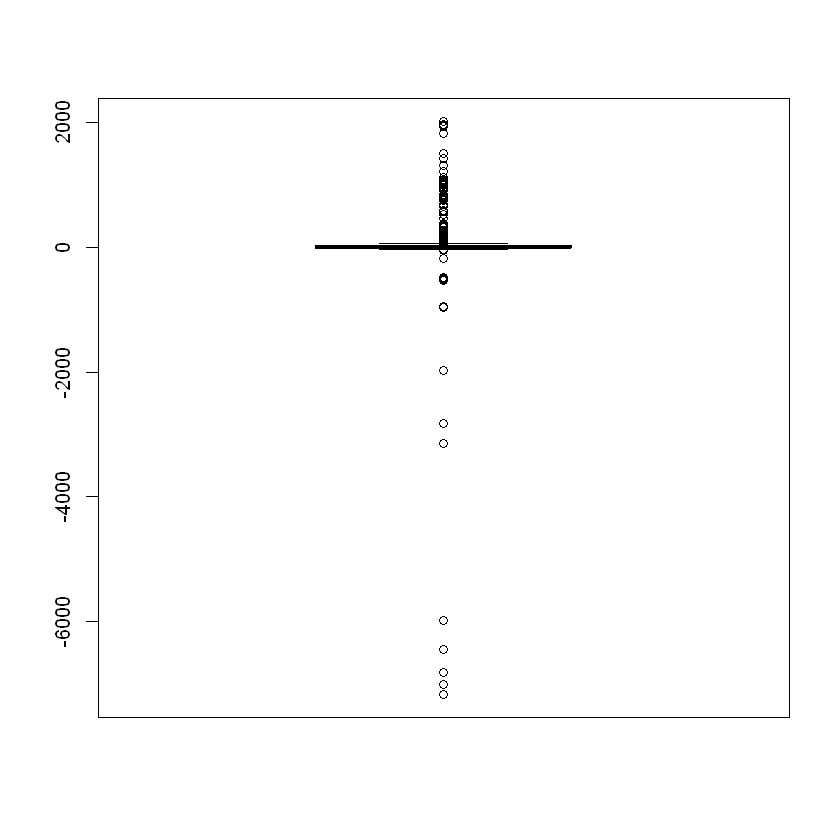

In [11]:
boxplot(members$bd) #several outliers and values that don't make sense

In [12]:
#flagging possible error values, based on https://report.twnic.tw/2018/TWNIC_TaiwanInternetReport_2018_EN.pdf
members$bd_flag <- ifelse(members$bd<12 | members$bd>65,1,0)

1% 68% 99% 
  0  16  54

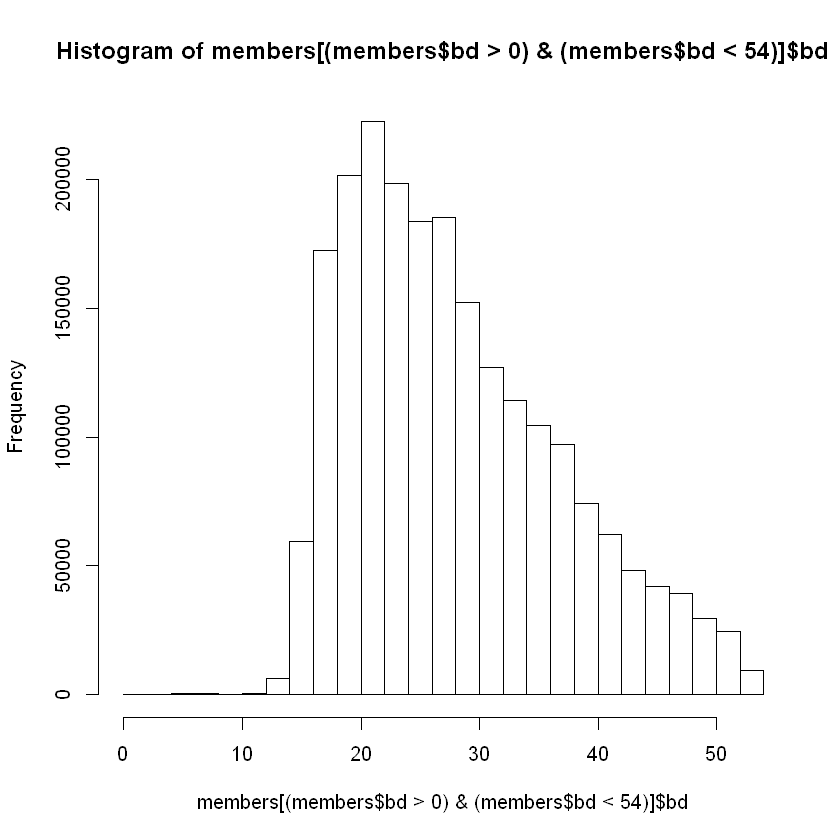

In [13]:
quantile(members$bd, c(.01, .68, .99)) 
#winsorizing hist, even though 0 is not really a valid age, only at 68% do we see a valid age (16) appear
hist(members[(members$bd>0)&(members$bd<54)]$bd) 

In [14]:
members$bd <- case_when(members$bd < 0 ~ 0,
                        members$bd > 54 ~ 54,
                        TRUE ~ as.numeric(members$bd))

In [15]:
summary(members$bd)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   9.656  21.000  54.000 

In [16]:
members$registration_init_time <- ymd(members$registration_init_time) #using lubridate to format date

In [26]:
max_reg <- max(members$registration_init_time) #last registration: 2017-04-29

In [37]:
#distance to last registration (how long has a user been with kkbox)
members$reg_time <- as.numeric(max_reg - members$registration_init_time) 

In [17]:
members$registration_year <- year(members$registration_init_time)

In [24]:
unique(members$registration_year) #14 unique values

[1] 2011 2014 2016 2017 2006 2007 2008 2009 2015 2013 2010 2012 2005 2004

In [18]:
members$registration_month <- month(members$registration_init_time)

In [35]:
members$reg_season <- ifelse(members$registration_month %in% c(12,1,2),"winter",
                            ifelse(members$registration_month %in% c(3,4,5),"spring",
                                  ifelse(members$registration_month %in% c(6,7,8),"summer","autumn")))

In [20]:
members$registration_day <- day(members$registration_init_time)

In [39]:
members$reg_month_early <- ifelse(members$registration_day<=15,1,0) #if user registered in first 2 weeks of month =1 else 0

In [46]:
#'reference': n-1 dummy variables
gender <- createDummyFeatures(members$gender, method = 'reference')
season <- createDummyFeatures(members$reg_season, method = 'reference')

In [56]:
members$reg_spring <- season['spring']
members$reg_summer <- season['summer']
members$reg_winter <- season['winter']
members$gender_male <- gender['male']
members$gender_unknown <- gender['unknown']

In [53]:
members$registration_init_time <- NULL
members$reg_season <- NULL
members$gender <- NULL
gender <- NULL
season <- NULL

In [57]:
#final table output
head(members)

msno,city,bd,registered_via,bd_flag,registration_year,registration_month,registration_day,reg_time,reg_month_early,reg_spring,reg_summer,reg_winter,gender_male,gender_unknown
<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,11,1,2011,9,11,2057,1,0,0,0,0,1
+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,7,1,2011,9,14,2054,1,0,0,0,0,1
cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,11,1,2011,9,15,2053,1,0,0,0,0,1
9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,11,1,2011,9,15,2053,1,0,0,0,0,1
WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,9,0,2011,9,15,2053,1,0,0,0,0,0
yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,4,30,9,0,2011,9,16,2052,0,0,0,0,1,0


#### Train

In [58]:
train <- fread(paste0(folder,'train.csv')) #churn info for February
#train_v2 <- fread(paste0(folder,'train_v2.csv')) #previous test.csv which contains the churn info for March

train <- rbind(train,fread(paste0(folder,'train_v2.csv')))
head(train)

msno,is_churn
<chr>,<int>
waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1
GBy8qSz16X5iYWD+3CMxv/Hm6OPSrXBYtmbnlRtknW0=,1


In [ ]:
dim(train)#970,960 users = rows

In [ ]:
summary(train)

#### Transactions

In [6]:
transactions <- fread(paste0(folder,'transactions.csv'))
#transactions_v2 <- fread(paste0(folder,'transactions_v2.csv')) #March transactions

transactions <- rbind(transactions,fread(paste0(folder,'transactions_v2.csv')))
head(transactions)

msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0
KN7I82kjY0Tn76Ny95ncqBUVbO7b8AXrOPqZutKpxIM=,21,30,149,149,1,20150930,20151107,0


In [10]:
#Checking rows and duplicates

dim(transactions) #22,978,755 rows
#length(unique(transactions$msno)) #2,426,143 unique users -> data must be aggregated

[1] 22978755        9

[1] 2426143

### Datamart Creation